# Compute confidence interval of SRC indices using linear regression

This examples shows how to compute SRC indices confidence bounds with linear regression methods. First, we compute SRC indices and draw them. Then we compute confidence bounds using methods from linear regression, and draw them.


In [1]:
import openturns as ot
import openturns.viewer as otv
from math import sqrt
import pylab as pl

We define the function g.

In [2]:
def functionCrue8vars(X):
    Q, Ks, Zv, Zm, Hd, Zb, L, B = X
    Zd = Zb + Hd
    alpha = (Zm - Zv) / L
    H = (Q / (Ks * B * sqrt(alpha))) ** (3.0 / 5.0)
    Zc = H + Zv
    S = Zc - Zd
    return [S]


g = ot.PythonFunction(8, 1, functionCrue8vars)
g.setDescription(["Q", "Ks", "Zv", "Zm", "Hd", "Zb", "L", "B", "S"])

Hd = 8.0
Zb = 55.5
L = 5000.0
B = 300.0
X = [Hd, Zb, L, B]
g_parametric = ot.ParametricFunction(g, [4, 5, 6, 7], X)

Then we define the random vector. 

In [3]:
Q = ot.Gumbel(558.0, 1013.0)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0, otLOW)
Ks = ot.Normal(30.0, 7.5)
Ks = ot.TruncatedDistribution(Ks, 0, otLOW)
Zv = ot.Uniform(49.0, 51.0)
Zm = ot.Uniform(54.0, 56.0)

X = ot.ComposedDistribution([Q, Ks, Zv, Zm])

We produce a pair of input and output sample.

In [4]:
sampleSize = 100
sampleX = X.getSample(sampleSize)
sampleY = g_parametric(sampleX)

importance_factors = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
print(importance_factors)

[0.378122,0.159565,0.180492,0.00565251]


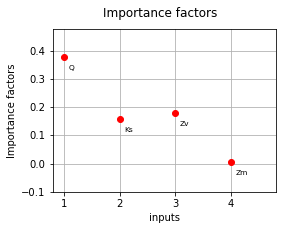

In [5]:
input_names = g_parametric.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    importance_factors, input_names, "Importance factors"
)
graph.setYTitle("Importance factors")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top = 0.1 + max(importance_factors))

In [6]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=4 values=[0,0,0,0] constant=class=Point name=Unnamed dimension=1 values=[-51.7738] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[0.00113853,-0.0669253,1.01919,-0.17428] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[0.00113853,-0.0669253,1.01919,-0.17428] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=4 columns=4 sheets=1 values=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [7]:
def define_linear_basis(dimension):
    """
    Compute a basis suitable for linear regression.
    
    This basis corresponds to the linear regression model:
    
    Y = beta[0] + beta[1] * X_1 + ... + beta[p] * X_p
   
    where p is the dimension.
    The first item of this basis corresponds to the intercept, i.e. 
    the function is constant and equal to 1.
    The remaining items are identity function, returning the corresponding 
    input variable.
    
    Parameters
    ----------
    dimension : int
        The number of dimensions of the input variable X.
    
    Returns
    -------
    basis : ot.Basis(1 + dimension)
        The functional basis.
    """
    list_of_inputs = ["x%d" % (i) for i in range(dimension)]
    # The intercept
    basis_list = []
    constant_function = ot.SymbolicFunction(list_of_inputs, ["1"])
    basis_list.append(constant_function)
    # The remaining functions
    for i in range(dimension):
        identity_function = ot.SymbolicFunction(list_of_inputs, ["x%d" % (i)])
        basis_list.append(identity_function)
    basis = ot.Basis(basis_list)
    return basis

In [8]:
def compute_least_squares_parameter_distribution(sampleX, sampleY):
    """
    Compute the gaussian distribution of the beta parameter.
    
    This distribution is valid under the hypothesis that the linear 
    least squares problem has a gaussian residual distribution.
    
    Parameters
    ----------
    sampleX : ot.Sample(size, input_dimension)
        The input sample.
    sampleY : ot.Sample(size, 1)
        The output sample.
    
    Returns
    -------
    distribution_betahat : ot.Normal()
        The gaussian distribution of beta_hat.
    """
    input_dimension = sampleX.getDimension()
    basis = define_linear_basis(input_dimension)
    design_proxy = ot.DesignProxy(sampleX , basis)
    n_parameters = len(basis)
    indices = list(range(n_parameters))
    design_matrix = design_proxy.computeDesign(indices)
    myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
    myLeastSquares.run()
    responseSurface = myLeastSquares.getMetaModel()
    predicted_outputs = responseSurface(sampleX)
    residuals_sample = sampleY - predicted_outputs
    residuals_sample.setDescription(["Residuals"])
    residuals_point = residuals_sample.asPoint()
    sample_size = sampleX.getSize()
    sigma2_hat = residuals_point.normSquare() / (sample_size - n_parameters)
    lsq_method = ot.QRMethod(design_proxy , indices)
    observation_point = sampleY.asPoint()
    beta_hat = lsq_method.solve(observation_point)
    inverse_gram = lsq_method.getGramInverse()
    covariance_matrix = ot.CovarianceMatrix(sigma2_hat * inverse_gram)
    distribution_betahat = ot.Normal(beta_hat , covariance_matrix)
    description = [r"$\beta_%d$" % (i) for i in range(n_parameters)]
    distribution_betahat.setDescription(description)
    return distribution_betahat

In [9]:
distribution_betahat = compute_least_squares_parameter_distribution(sampleX, sampleY)
beta_hat = distribution_betahat.getMean()
print("hat(Beta) = ", beta_hat)

hat(Beta) =  [-51.7738,0.00113853,-0.0669253,1.01919,-0.17428]


In [10]:
# Compute quantiles
alpha = 0.05
dimension = sampleX.getDimension()
beta_lower_bound = ot.Point(1 + dimension)
beta_upper_bound = ot.Point(1 + dimension)
# We include the distribution of the intercept
for i in range(1 + dimension):
    marginal_beta_distribution = distribution_betahat.getMarginal(i)
    marginal_beta_bounds = marginal_beta_distribution.computeBilateralConfidenceInterval(1.0 - alpha)
    beta_lower_bound[i] = marginal_beta_bounds.getLowerBound()[0]
    beta_upper_bound[i] = marginal_beta_bounds.getUpperBound()[0]
beta_bounds = ot.Interval(beta_lower_bound, beta_upper_bound)
print(beta_bounds)

[-60.812, -42.7356]
[0.00103796, 0.0012391]
[-0.0758696, -0.0579811]
[0.896351, 1.14204]
[-0.291698, -0.0568613]


In [11]:
variance_Y = sampleY.computeCovariance()[0, 0]
print("variance_Y = %.3f" % (variance_Y))

variance_Y = 1.880


We are interested in the importance factors :
$$
\eta_i = \frac{\beta_i^2 \mathbb{V}(X_i)}{\mathbb{V}(Y)}
$$
for $i = 1, ..., p$. 

In the next cell, we compute the importance factors using the linear regression. We are interested only in the coefficients $\hat{\beta}_1, ..., \hat{\beta}_p$ and not in $\hat{\beta}_0$, which is why we have to use a shift of +1 in the indices. 

In [12]:
importance_factors = ot.Point(dimension)
for i in range(dimension):
    marginal_input_distribution = X.getMarginal(i)
    variance_X_i = marginal_input_distribution.getCovariance()[0, 0]
    # We shift beta, because we do not consider the intercept here.
    importance_factors[i] = beta_hat[1 + i] ** 2 * variance_X_i / variance_Y
print(importance_factors)

[0.350857,0.133918,0.184145,0.00538444]


In order to compute confidence bounds of the importance factors, we recognize that if $Z \sim \mathcal{N}(\mu, \sigma^2)$, then $Z^2$ has a [noncentral chi-squared distribution with one degree of freedom](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution). More precisely, the random variable $\frac{Z}{\sigma}$ is $\mathcal{N}(\mu, 1)$, which implies that $\left(\frac{Z}{\sigma}\right)^2$ has a noncentral chi-squared distribution with a non centrality parameter $\lambda = \left(\frac{\mu}{\sigma}\right)^2$. 

The variable $Z^2$ is a chi-squared distribution if $\mu = 0$ and $\sigma^2 = 1$. The chi-squared case is unlikely to happen, since we consider a coefficient $\hat{\beta}$ which mean is not necessarily zero and variance is not necessarily equal to 1. 

In the following cell, we compute the bounds using the arithmetic of distributions, which leads to a `SquaredNormal` distribution. 

In [13]:
importance_factors_lower_bound = ot.Point(dimension)
importance_factors_upper_bound = ot.Point(dimension)
for i in range(dimension):
    marginal_input_distribution = X.getMarginal(i)
    variance_X_i = marginal_input_distribution.getCovariance()[0, 0]
    marginal_beta_distribution = distribution_betahat.getMarginal(1 + i)
    # Use the arithmetic of distributions
    squared_beta = marginal_beta_distribution ** 2  
    marginal_bounds = squared_beta.computeBilateralConfidenceInterval(1.0 - alpha)
    squared_beta_lower_bound = marginal_bounds.getLowerBound()[0]
    squared_beta_upper_bound = marginal_bounds.getUpperBound()[0]
    importance_factors_lower_bound[i] = squared_beta_lower_bound * variance_X_i / variance_Y
    importance_factors_upper_bound[i] = squared_beta_upper_bound * variance_X_i / variance_Y
importance_factors_bounds = ot.Interval(importance_factors_lower_bound, importance_factors_upper_bound)
print(importance_factors_bounds)

[0.291611, 0.415579]
[0.0236689, 0.0236689]
[0.142431, 0.23121]
[0.000574341, 0.0150839]


In [14]:
def plot_importance_factors_with_bounds(
    importance_factors, input_names, alpha, importance_bounds
):
    """
    Plot importance factors indices with confidence bounds of level 1 - alpha
    
    Parameters
    ----------
    importance_factors : ot.Point(dimension)
        The importance factors.
    input_names : list(str)
        The names of the input variables.
    alpha : float, in [0, 1]
        The complementary confidence level.
    importance_bounds : ot.Interval(dimension)
        The lower and upper bounds of the importance factors
    
    Returns
    -------
    graph : ot.Graph
        The importance factors indices with lower and upper 1-alpha confidence intervals.
    """
    dim = importance_factors.getDimension()
    lowerBounds = importance_bounds.getLowerBound()
    upperBounds = importance_bounds.getUpperBound()
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        importance_factors, input_names, "Importance factors"
    )
    graph.setYTitle("Importance factors")
    title = "Importance factors with bounds at %.2f %%" % ((1 - alpha) * 100)

    graph.setTitle(title)
    # Add confidence bounds
    for i in range(dim):
        curve = ot.Curve([1 + i, 1 + i], [lowerBounds[i], upperBounds[i]])
        graph.add(curve)
    return graph

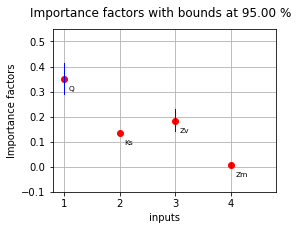

In [15]:
graph = plot_importance_factors_with_bounds(importance_factors, input_names, alpha, importance_factors_bounds)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top = 0.2 + max(importance_factors))